<div align="center">
<a href="https://vbti.nl"><img src="https://docs.google.com/uc?export=download&id=1DdCGllL51O5wBuiI0rwygofKx3YIDPHX" width="400"></a>
</div>


# Miniproject: Time Series Classification with Human Activity Dataset

In this notebook, we will build and train deep learning models for time series classification (TSC). 

Smartphones are advanced devices with many different types of sensors. An 'average' smartphone already contains acceleration sensors, gyroscopes, camera('s), microphone(s), and more. By processing the data from these sensors in a smart way, we can determine what a user (carrying the mobile phone) is doing. This so-called 'context information of the user' is very useful to build smart applications.

One recent example of a smart application using the context information of a user is the 'handwashing monitoring' application in Apple's iWatch. This application helps to prevent getting and spreading the Coronavirus. When a user arrives at home the iWatch gives a signal to wash the hands. The iWatch is able to detect when a user starts washing his/her hands and when the user is ready. This is done using the motion sensors of the iWatch. When a user washes his/her hands for more than 20 seconds a reward is given.

Next to motion sensing, mobile phones and smartwatches will get more and more sensors to measure bio-signals, such as heart rate, blood pressure, skin conductivity, and temperature. All in all, more time-series data is generated by these devices, and time-series models are needed to do something useful with the data.

In this notebook, we will build times series classification models to detect the activity of a user using motion data from a mobile phone. We will use the 'human activity' dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). 


## Dataset
The following description is taken from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) website.

The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually. The obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers were selected for generating the training data and 30% for the test data. 

The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low-frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. From each window, a vector of features was obtained by calculating variables from the time and frequency domain.

Check the README.txt file for further details about this dataset. 

A video of the experiment including an example of the 6 recorded activities with one of the participants can be seen below.

### Download Data

In [1]:
import os
import os.path as osp

import requests
from tqdm.autonotebook import tqdm


def download_file(url, path, overwrite=False):
    """
    Download file and save it to the defined location

    https://stackoverflow.com/questions/37573483/progress-bar-while-download-file-over-http-with-requests/37573701
    """

    if osp.exists(path) and not overwrite:
        print("{} already exists. Skipping download ...".format(path))
        return

    root_dir, _ = osp.split(path)
    os.makedirs(root_dir, exist_ok=True)

    response = requests.get(url, stream=True)
    total_size_in_bytes = int(response.headers.get("content-length", 0))
    block_size = 1024  # 1 Kibibyte
    progress_bar = tqdm(total=total_size_in_bytes, unit="iB", unit_scale=True)
    with open(path, "wb") as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR, something went wrong")

        
from zipfile import ZipFile


def unzip(archive_path, extract_to=None):
    with ZipFile(archive_path, "r") as zf:
        zf.extractall(extract_to)
    
import os
from os.path import join
os.makedirs('data', exist_ok=True)
PATH_TO_ZIP = join('data', 'HAPT.zip')
URL = 'https://github.com/illyakaynov/masterclass_datasets/raw/master/RNN%20and%20Transformers/UCI%20HAR%20Dataset.zip'
DATA_FOLDER = join('data', 'HAPT')


download_file(URL, PATH_TO_ZIP)
unzip(PATH_TO_ZIP, DATA_FOLDER)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """


### Exploring Data
Importing and preparing data always require some effort. Our dataset is stored in txt files. It is insightful to open one of these txt files yourself and check how to data is stored. We will use the `read_fwf` function from pandas to read the data. This function reads a table of fixed-width formatted lines into DataFrame.

Now we are going to load the data. From the description, we know that we have multiple sensor readings. Each sensor has different features and for each feature, we have multiple readings which are represented as time-series data.

Sensor -> Feature -> Time-series -> Data point.

We are going to encode the sensor name in a feature name, therefore we will only be working with features. For each feature, we will have a table where a row represents a time series and column includes a momentary reading on a particular timestep.

The data is already split into train and test for us.

In [2]:
import pandas as pd

# root to dataset
PATH = join('data', 'HAPT', 'UCI HAR Dataset')

# list of feature names
features = ['body_acc_x', 'body_acc_y', 'body_acc_z', \
            'body_gyro_x', 'body_gyro_y', 'body_gyro_z', \
            'total_acc_x', 'total_acc_y', 'total_acc_z']

# import train data
data_train = {}
for fn in features:
    filename = join(PATH, 'train', 'Inertial Signals', fn + '_train.txt')
    data_train[fn] = pd.read_fwf(filename, header=None)

# labels are from 1 to 6, we use 0 to 5    
data_train['y'] = pd.read_fwf(join(PATH, 'train', 'y_train.txt'), header=None)  - 1  

# import test data
data_test = {}
for fn in features:
    filename = join(PATH, 'test', 'Inertial Signals', fn + '_test.txt')
    data_test[fn] = pd.read_fwf(filename, header=None)
    
# labels are from 1 to 6, we use 0 to 5    
data_test['y'] = pd.read_fwf(join(PATH, 'test', 'y_test.txt'), header=None) - 1  

# define activity labels
labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']

In [3]:
data_train.keys()

dict_keys(['body_acc_x', 'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'total_acc_x', 'total_acc_y', 'total_acc_z', 'y'])

In [4]:
# example of a feature
data_train['body_acc_x']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0.000181,0.010139,0.009276,0.005066,0.010810,0.004045,0.004757,0.006214,0.003307,0.007572,0.005407,0.006221,0.006895,0.004610,0.007331,0.005078,0.005763,0.006693,0.005443,0.008241,0.006506,0.006532,0.007422,0.005772,0.006240,0.004623,0.004833,0.005499,0.004341,0.005098,0.004269,0.003045,0.003204,0.004520,0.005127,0.003550,0.004234,0.004469,0.003573,0.005136,...,0.000389,0.001328,0.002053,0.002738,0.002743,0.001330,-0.000367,-0.000722,-0.001904,-0.004294,-0.000025,0.005251,0.002490,0.000811,0.001166,-0.000693,-0.000077,0.000504,-0.000495,0.000156,0.000065,-0.000320,0.000185,-0.000375,-0.001013,-0.001611,-0.001765,-0.000636,0.001047,0.003019,0.001412,-0.001509,0.000060,0.000435,-0.000819,0.000228,-0.000300,-0.001147,-0.000222,0.001576
1,0.001094,0.004550,0.002879,0.002247,0.003305,0.002416,0.001619,0.000981,0.000009,-0.000363,-0.000487,-0.000356,-0.000229,-0.000131,-0.000441,-0.001565,-0.000929,0.000009,-0.001236,-0.000911,-0.000435,-0.001177,0.000165,0.000751,0.000389,0.001328,0.002053,0.002738,0.002743,0.001330,-0.000367,-0.000722,-0.001904,-0.004294,-0.000025,0.005251,0.002490,0.000811,0.001166,-0.000693,...,-0.001506,-0.002105,-0.001494,0.002181,0.002876,0.000871,-0.000392,-0.000569,0.000569,-0.001176,-0.001957,-0.000471,0.000208,0.003380,0.004829,0.003380,0.001088,-0.001249,0.000387,0.000533,-0.000679,0.000594,-0.000084,-0.000142,0.000784,0.001507,0.003386,0.002166,0.000422,0.000854,-0.000104,-0.000141,0.001333,0.001541,0.001077,-0.000736,-0.003767,-0.004646,-0.002941,-0.001599
2,0.003531,0.002285,-0.000420,-0.003738,-0.006706,-0.003148,0.000733,0.000668,0.002162,-0.000946,-0.006476,-0.003423,-0.000610,-0.002929,-0.001796,0.000956,0.002311,0.002538,0.001180,0.001217,0.000869,0.000686,0.002156,0.000478,-0.001506,-0.002105,-0.001494,0.002181,0.002876,0.000871,-0.000392,-0.000569,0.000569,-0.001176,-0.001957,-0.000471,0.000208,0.003380,0.004829,0.003380,...,0.002138,0.003519,0.002715,0.002370,0.003299,0.002357,0.001481,-0.000340,-0.002201,0.000124,0.002345,0.002706,0.001281,-0.000949,0.000890,0.004952,0.007315,0.004242,-0.002776,-0.004625,-0.001945,0.002561,0.007382,0.005730,0.002901,0.002896,0.000533,0.000552,0.001286,-0.000926,0.000661,0.001853,-0.000268,-0.000394,-0.000279,-0.000316,0.000144,0.001246,0.003117,0.002178
3,-0.001772,-0.001311,0.000388,0.000408,-0.000355,0.000998,0.001109,-0.003149,-0.008882,-0.010483,-0.004482,0.004528,0.008167,0.002929,-0.004487,-0.004717,-0.001637,-0.000097,0.001614,0.002619,0.004765,0.005851,0.002579,0.000677,0.002138,0.003519,0.002715,0.002370,0.003299,0.002357,0.001481,-0.000340,-0.002201,0.000124,0.002345,0.002706,0.001281,-0.000949,0.000890,0.004952,...,0.001470,0.001644,-0.000106,-0.001683,-0.001165,0.000241,0.000216,-0.000102,-0.001546,-0.003518,-0.003204,-0.002376,-0.001825,-0.001754,-0.002504,-0.002612,-0.002715,-0.001748,0.000066,-0.000050,-0.000898,-0.001478,-0.000698,0.000441,-0.001206,-0.002607,-0.001986,-0.001230,-0.001129,-0.001334,0.000458,0.002103,0.001358,0.000820,-0.000212,-0.001915,-0.001631,-0.000867,-0.001172,-0.000028
4,0.000087,-0.000272,0.001022,0.003126,0.002284,0.000885,0.001933,0.002270,0.002247,0.002175,0.001750,0.001420,0.000297,0.000665,0.001911,0.001778,0.001087,-0.000716,-0.001347,-0.000384,-0.000135,0.000666,0.000656,0.000221,0.001470,0.001644,-0.000106,-0.001683,-0.001165,0.000241,0.000216,-0.000102,-0.001546,-0.003518,-0.003204,-0.002376,-0.001825,-0.001754,-0.002504,-0.002612,...,-0.001015,0.001832,0.001169,0.000362,-0.002587,-0.002581,0.001470,0.003026,0.003734,0.001870,-0.000212,0.000945,0.001956,0.002602,0.001366,0.000665,-0.000459,-0.004151,-0.003591,-0.001328,-0.000153,0.001043,0.000407,-0.000614,-0.002858,-0.003824,-0.001411,0.000765,0.001153,0.000627,0.002529,0.003518,-0.000248,-0.002761,

In [ ]:
# example of a feature
data_train['body_acc_x']

In [5]:
# label
data_train['total_acc_y']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,-0.123217,-0.126876,-0.124004,-0.124928,-0.125767,-0.124462,-0.127361,-0.127891,-0.125868,-0.124368,-0.123138,-0.121334,-0.118358,-0.120062,-0.122119,-0.120080,-0.120902,-0.121395,-0.121568,-0.124681,-0.125490,-0.124935,-0.124906,-0.124993,-0.125155,-0.124799,-0.125479,-0.126807,-0.127289,-0.123713,-0.119263,-0.122697,-0.127122,-0.126278,-0.126142,-0.125169,-0.121594,-0.119056,-0.117913,-0.117403,...,-0.122158,-0.123397,-0.127263,-0.130238,-0.131286,-0.130000,-0.127771,-0.123909,-0.119738,-0.121468,-0.126012,-0.128220,-0.126367,-0.121747,-0.121880,-0.123966,-0.124257,-0.126150,-0.127650,-0.129588,-0.130348,-0.129979,-0.132165,-0.128870,-0.124246,-0.126746,-0.127045,-0.125637,-0.126780,-0.125855,-0.123493,-0.121995,-0.123910,-0.127970,-0.128295,-0.127010,-0.126185,-0.124070,-0.122745,-0.121326
1,-0.123976,-0.126808,-0.127786,-0.126655,-0.123634,-0.124919,-0.124300,-0.119798,-0.119222,-0.120174,-0.121316,-0.122291,-0.126494,-0.132631,-0.128624,-0.122015,-0.121854,-0.121211,-0.120603,-0.120948,-0.121218,-0.123681,-0.125553,-0.124199,-0.122158,-0.123397,-0.127263,-0.130238,-0.131286,-0.130000,-0.127771,-0.123909,-0.119738,-0.121468,-0.126012,-0.128220,-0.126367,-0.121747,-0.121880,-0.123966,...,-0.117351,-0.117708,-0.120567,-0.121626,-0.120834,-0.121511,-0.120537,-0.122659,-0.125076,-0.123420,-0.119909,-0.113072,-0.112683,-0.118773,-0.123633,-0.128660,-0.121679,-0.108560,-0.108818,-0.111929,-0.113335,-0.118399,-0.120435,-0.119145,-0.117269,-0.115695,-0.114043,-0.111686,-0.112778,-0.115743,-0.117672,-0.119885,-0.122055,-0.122978,-0.122969,-0.127339,-0.132329,-0.129027,-0.126424,-0.130519
2,-0.120016,-0.121499,-0.122841,-0.123717,-0.123817,-0.121304,-0.121258,-0.125411,-0.129458,-0.129856,-0.127783,-0.125683,-0.121083,-0.117871,-0.118179,-0.117495,-0.117420,-0.116524,-0.116636,-0.120972,-0.125692,-0.129232,-0.126144,-0.119488,-0.117351,-0.117708,-0.120567,-0.121626,-0.120834,-0.121511,-0.120537,-0.122659,-0.125076,-0.123420,-0.119909,-0.113072,-0.112683,-0.118773,-0.123633,-0.128660,...,-0.131393,-0.130453,-0.131171,-0.129933,-0.129450,-0.129804,-0.129180,-0.131421,-0.130716,-0.129749,-0.131428,-0.130043,-0.129670,-0.126487,-0.121685,-0.123728,-0.125686,-0.126648,-0.129585,-0.130562,-0.130751,-0.132542,-0.133325,-0.130517,-0.127259,-0.127273,-0.128325,-0.128341,-0.131299,-0.135513,-0.134438,-0.133090,-0.134369,-0.133016,-0.130937,-0.130473,-0.130305,-0.130876,-0.131210,-0.130183
3,-0.133404,-0.134364,-0.135203,-0.134048,-0.130632,-0.123746,-0.118772,-0.122888,-0.127193,-0.126323,-0.127280,-0.128284,-0.126820,-0.123751,-0.118452,-0.116749,-0.119566,-0.122615,-0.127409,-0.132999,-0.137142,-0.137056,-0.132648,-0.131304,-0.131393,-0.130453,-0.131171,-0.129933,-0.129450,-0.129804,-0.129180,-0.131421,-0.130716,-0.129749,-0.131428,-0.130043,-0.129670,-0.126487,-0.121685,-0.123728,...,-0.129600,-0.130723,-0.130925,-0.130051,-0.132337,-0.137606,-0.143545,-0.141507,-0.135970,-0.135658,-0.132345,-0.128695,-0.129707,-0.129693,-0.131397,-0.133899,-0.135654,-0.137265,-0.135319,-0.134463,-0.132504,-0.128881,-0.130835,-0.131154,-0.129785,-0.130892,-0.129341,-0.128031,-0.128397,-0.128371,-0.127894,-0.127629,-0.129888,-0.130819,-0.128451,-0.126481,-0.127507,-0.131986,-0.134507,-0.133316
4,-0.128731,-0.127846,-0.128230,-0.129854,-0.132752,-0.133991,-0.131159,-0.129970,-0.131889,-0.133298,-0.134566,-0.134545,-0.132740,-0.130512,-0.129979,-0.131008,-0.130450,-0.130911,-0.133531,-0.134933,-0.133370,-0.130811,-0.131721,-0.131759,-0.129600,-0.130723,-0.130925,-0.130051,-0.132337,-0.137606,-0.143545,-0.141507,-0.135970,-0.135658,-0.132345,-0.128695,-0.129707,-0.129693,-0.131397,-0.133899,...,-0.132685,-0.133022,-0.132084,-0.128511,-0.122917,-0.124986,-0.129536,-0.130391,-0.130591,-0.126080,-0.1231

In [31]:
import matplotlib.pyplot as plt

def plot_timeseries(data, idx, ylim=None):
    """Plot time serie data."""
    fig, axs = plt.subplots(3, 1, figsize=(14, 7))
    fig.subplots_adjust(top=0.95)

    for j in range(9):
        i = j // 3
        axs[i].plot(data[features[j]].values[idx,:], label=features[j])
        if ylim:
            axs[i].set_ylim(ylim)
        axs[i].legend()
    plt.suptitle(labels[data_train['y'].values[idx][0]])

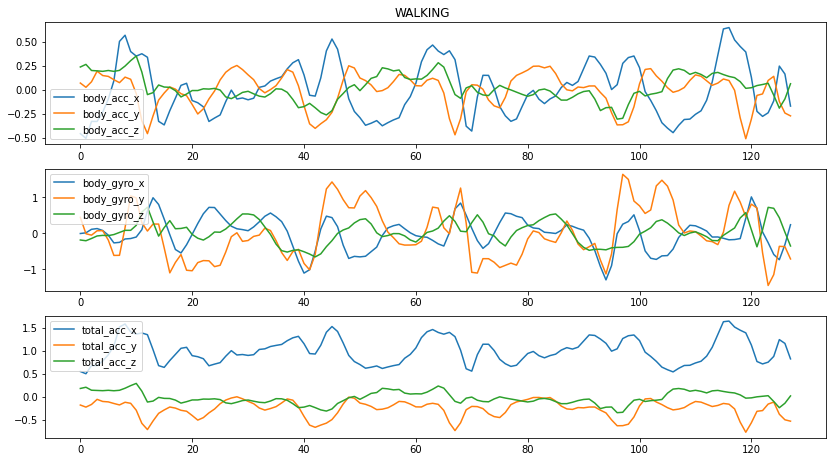

In [32]:
plot_timeseries(data_train, idx=100)

From the plot above we can notice that the features have a different range. Let's have a look at the ranges by taking the minimum and maximum across all features.

In [8]:
f_min, f_max = {}, {}
for f in features:
    f_min[f] = min(data_train[f].min().min(), data_test[f].min().min())
    f_max[f] = max(data_train[f].max().max(), data_test[f].max().max())

In [9]:
f_min

{'body_acc_x': -1.232238,
 'body_acc_y': -1.345267,
 'body_acc_z': -1.364707,
 'body_gyro_x': -4.733656,
 'body_gyro_y': -5.97433,
 'body_gyro_z': -2.763014,
 'total_acc_x': -0.4665558,
 'total_acc_y': -1.588211,
 'total_acc_z': -1.639609}

In [10]:
f_max

{'body_acc_x': 1.2999120000000002,
 'body_acc_y': 0.9759764,
 'body_acc_z': 1.066916,
 'body_gyro_x': 4.155473000000001,
 'body_gyro_y': 5.746062,
 'body_gyro_z': 2.365982,
 'total_acc_x': 2.197618,
 'total_acc_y': 1.21735,
 'total_acc_z': 1.281363}

Since the range for different features varies a lot it is a good idea to normalize all of the features.

### Preparing Data for Training

**Task 1a**: Standartize/Normalize the training and validation data.

In [19]:
data_train_norm = {}
data_test_norm = {}

for f in features:
    data_train_norm[f] = (data_train[f] - f_min[f]) / (f_max[f] - f_min[f])
    data_test_norm[f] = (data_test[f] - f_min[f]) / (f_max[f] - f_min[f])

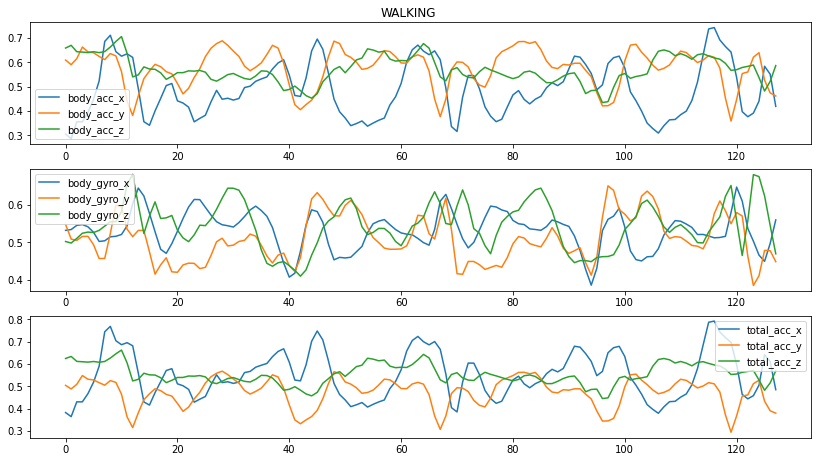

In [33]:
plot_timeseries(data_train_norm, idx=100)

**Task 1b**: Build tensors for model training


In [37]:
import numpy as np

n_batches_train = data_train['body_acc_x'].shape[0]
n_batches_val   = data_test['body_acc_x'].shape[0]
n_timesteps     = data_train['body_acc_x'].shape[1]
n_inputs = len(features)
n_outputs = 1

# create train set
X_train = np.empty((n_batches_train, n_timesteps, n_inputs))
y_train = np.empty(n_batches_train)

for i, f in enumerate(features):
    X_train[:,:,i] = data_train_norm[f].values
y_train = data_train['y'].values[:, 0]

# validation set
# the test set is used as validation set
X_val = np.empty((n_batches_val, n_timesteps, n_inputs))
y_val = np.empty(n_batches_val)

for i, f in enumerate(features):
    X_val[:,:,i] = data_test_norm[f].values
y_val = data_test['y'].values[:,0]

In [38]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((7352, 128, 9), (7352,), (2947, 128, 9), (2947,))

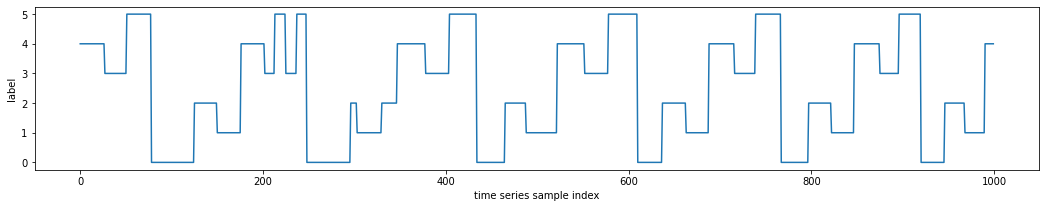

In [39]:
plt.figure(figsize=(18,3))
plt.plot(y_train[:1000])
plt.xlabel('time series sample index')
plt.ylabel('label');

In [40]:
# reformat target vector from categorical label to one-hot-encoding
from tensorflow.keras import utils

n_classes = len(np.unique(y_train))

# reformat labels to one-hot-encoded labels
print('Before y_train[0] = {}'.format(y_train[0]))
y_train_onehot = utils.to_categorical(y_train, n_classes)
y_val_onehot = utils.to_categorical(y_val, n_classes)
print('After y_train[0] = {}'.format(y_val_onehot[0]))

Before y_train[0] = 4
After y_train[0] = [0. 0. 0. 0. 1. 0.]


## Modeling

**Task 2a**: Build a recurent neural netwok for classification

In [84]:
import tensorflow as tf

hidden_state_dim = 50

model  = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(hidden_state_dim, 
                              input_shape=[None, n_inputs],
                              activation='linear',
                              # return_sequences=True,
                              use_bias=True),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(n_classes, 
                              activation='softmax',
                              use_bias=True)   
])

optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["categorical_accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [85]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_13 (SimpleRNN)    (None, 50)                3000      
_________________________________________________________________
dense_13 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 606       
Total params: 8,706
Trainable params: 8,706
Non-trainable params: 0
_________________________________________________________________


In [86]:
history = model.fit(X_train, y_train_onehot, epochs=50, validation_data=(X_val, y_val_onehot), verbose=2)

Epoch 1/50
230/230 - 6s - loss: 1.3451 - categorical_accuracy: 0.4771 - val_loss: 1.0639 - val_categorical_accuracy: 0.5864
Epoch 2/50
230/230 - 5s - loss: 1.0550 - categorical_accuracy: 0.5839 - val_loss: 0.9863 - val_categorical_accuracy: 0.5857
Epoch 3/50
230/230 - 5s - loss: 0.9118 - categorical_accuracy: 0.6162 - val_loss: 0.8548 - val_categorical_accuracy: 0.6149
Epoch 4/50
230/230 - 5s - loss: 0.7910 - categorical_accuracy: 0.6483 - val_loss: 0.8414 - val_categorical_accuracy: 0.6396
Epoch 5/50
230/230 - 5s - loss: 0.7637 - categorical_accuracy: 0.6617 - val_loss: 0.7763 - val_categorical_accuracy: 0.6556
Epoch 6/50
230/230 - 5s - loss: 0.7096 - categorical_accuracy: 0.6812 - val_loss: 0.7918 - val_categorical_accuracy: 0.6505
Epoch 7/50
230/230 - 5s - loss: 0.6570 - categorical_accuracy: 0.7069 - val_loss: 1.0590 - val_categorical_accuracy: 0.6074
Epoch 8/50
230/230 - 5s - loss: 0.6814 - categorical_accuracy: 0.7031 - val_loss: 0.7378 - val_categorical_accuracy: 0.6447
Epoch 9/

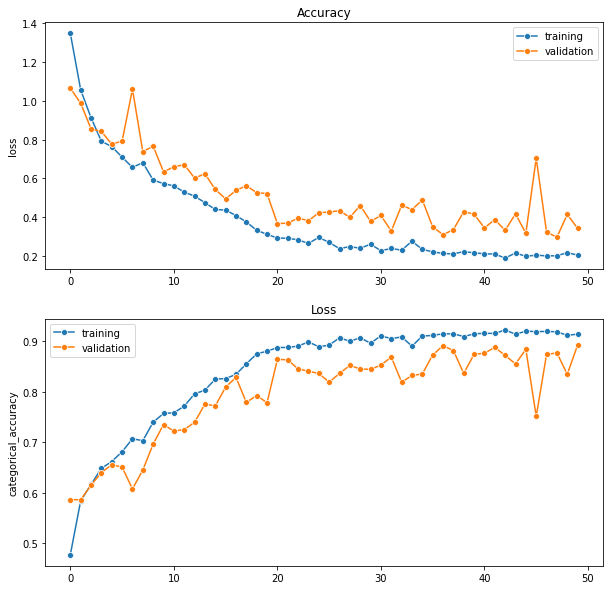

In [87]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# visualize the training process
def visualize_training_process(history):
    """
    Visualize loss and accuracy from training history

    :param history: A Keras History object
    """
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    axs = axs.ravel()  # make 1D array for easy plotting in for loop

    df = pd.DataFrame(history.history)

    axs[0].set_title("Accuracy")
    sns.lineplot(data=df, x=df.index, y="loss", ax=axs[0], label="training", marker="o")
    sns.lineplot(
        data=df, x=df.index, y="val_loss", ax=axs[0], label="validation", marker="o"
    )

    axs[1].set_title("Loss")
    sns.lineplot(
        data=df,
        x=df.index,
        y="categorical_accuracy",
        ax=axs[1],
        label="training",
        marker="o",
    )
    sns.lineplot(
        data=df,
        x=df.index,
        y="val_categorical_accuracy",
        ax=axs[1],
        label="validation",
        marker="o",
    )
    plt.show()
    
visualize_training_process(history)

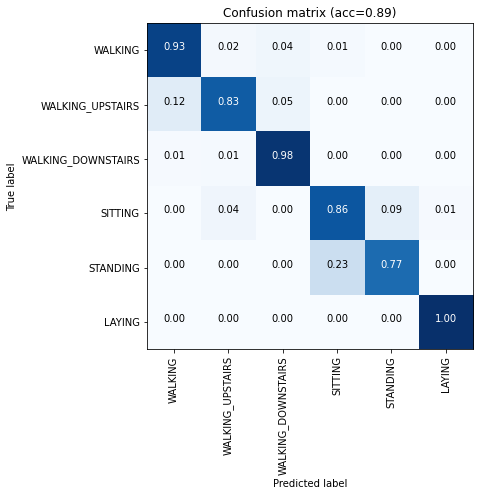

In [89]:
# Evaluate performance of model by plotting confusion matrix
from sklearn.metrics import confusion_matrix

# see http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools

def accuracy(y, y_pred):
    return np.sum(y==y_pred)/len(y)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6,6))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    cm = cm[::-1,:]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xlim((-0.5, len(classes) - 0.5))
    plt.ylim((-0.5, len(classes) - 0.5))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes[::-1])
    plt.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label');
    
# predict labels from validation set
y_pred = model.predict(X_val)

# convert data to label number
y_pred = np.argmax(y_pred, axis=1) 

# compute the confusion matrix
cm = confusion_matrix(y_val, y_pred) 

# plot the confusion matrix
plot_confusion_matrix(cm, normalize=True,
                      title='Confusion matrix (acc={:0.2f})'.format(accuracy(y_val, y_pred)), 
                      classes = labels)

**Task 2b**: Build a 1D Convolution Neural Network for classification

In stead of using RNNs we can also use 1D convolutional networks. The paper ["Time Series Classification from Scratch with Deep Neural Networks: A Strong Baseline"](https://arxiv.org/pdf/1611.06455.pdf) gives an overview of techniques for time series classification. Here we adopt the baseline model from the paper that give the best performance.

In [ ]:
model = ... #---YOUR CODE HERE---

In [ ]:
history = model.fit(... #---YOUR CODE HERE---

In [ ]:
visualize_training_process(history)

In [ ]:
# predict labels from validation set
y_pred = model.predict(X_val)

# convert data to label number
y_pred = np.argmax(y_pred, axis=1) 

# compute the confusion matrix
cm = confusion_matrix(y_val, y_pred) 

# plot the confusion matrix
plot_confusion_matrix(cm, 
                      title='Confusion matrix (acc={:0.2f})'.format(accuracy(y_val, y_pred)), 
                      classes = labels)

## Discussion:
- Which model achives better performance?
- Which model is faster to train?
- What do you think is the advantage of one model over the other?